## Importing packages

In [ ]:
!pip install pandas matplotlib numpy --quiet

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

#### Loading CSV into memory.
In this case, you have to download csv by yourself, in this case, it used Tick Data Suite download which had 3 columns representing time, bid and ask (respectively) for each row.

In [3]:
#Load dataset
csv_location = "/run/media/nicolas/SHARED/data/EURUSD_GMT+0_NO-DST_2003-2024_M30.csv"
dataset = pd.read_csv(csv_location, parse_dates=['Date'])

# Merging Date and Minutes columns and setting Time column as the index of this DataFrame
dataset.loc[:,'Time'] = pd.to_datetime(dataset.Date.astype(str)+' '+dataset.Time.astype(str))
dataset.pop('Date')
dataset.pop('Tick volume')
dataset.set_index('Time', inplace=True)
initial_dataset_size = len(dataset)

dataset.head()

/home/nicolas/.local/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,Open,High,Low,Close
Time,,,,
2003-05-04 21:00:00,1.12284,1.12338,1.12242,1.12297
2003-05-04 21:30:00,1.12287,1.12313,1.12264,1.12305
2003-05-04 22:00:00,1.12274,1.12287,1.12226,1.12261
2003-05-04 22:30:00,1.12261,1.12302,1.12235,1.12241
2003-05-04 23:00:00,1.12235,1.12235,1.12160,1.12197


#### Checking data types and length

In [4]:
print(f"Data length: {initial_dataset_size} rows.\n")
print(f"{dataset.dtypes}")

Data length: 262142 rows.

Open     float64
High     float64
Low      float64
Close    float64
dtype: object


## Analysis
Next, we are gonna use LSTM and GRU models to make predictions of the price in the recent years

#### Formatting data and necessary columns

In [5]:
dataset.describe()

,Open,High,Low,Close
count,262142.000000,262142.000000,262142.000000,262142.000000
mean,1.232724,1.233420,1.232027,1.232726
std,0.127095,0.127229,0.126948,0.127096
min,0.953900,0.955420,0.953570,0.953900
25%,1.124050,1.124592,1.123540,1.124042
50%,1.216735,1.217380,1.216100,1.216750
75%,1.326350,1.327130,1.325550,1.326338
max,1.601300,1.603890,1.599190,1.601420


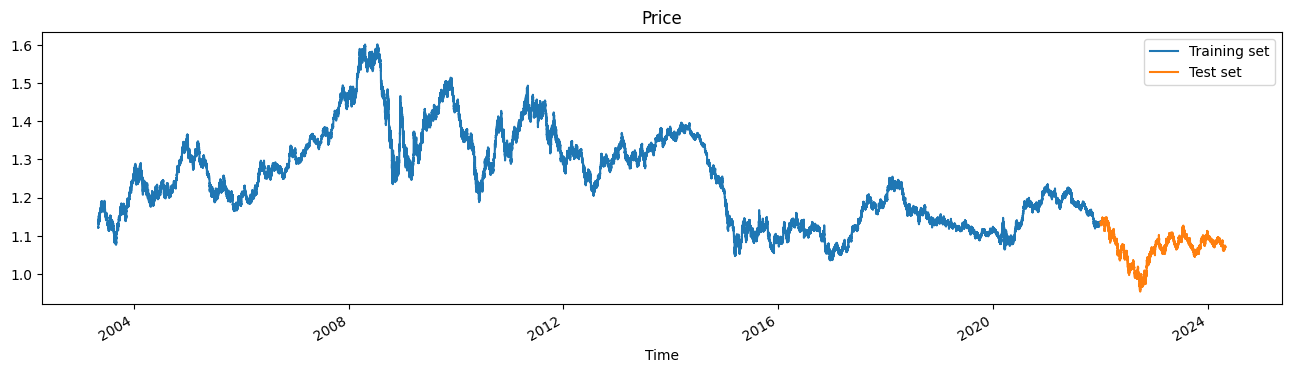

In [6]:
dataset["Close"][:'2021'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2022':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title('Price')
plt.show()

# Calculating some price values
Now, let's take a look at some technical indicator that could be useful for our experiments

### Simple Moving Average
Let's code a SMA column for each one of the candles

In [55]:
sma_value = 175 # SMA Period
dataset['slow_sma'] = dataset['Close'].rolling(window=sma_value, min_periods=1).mean()

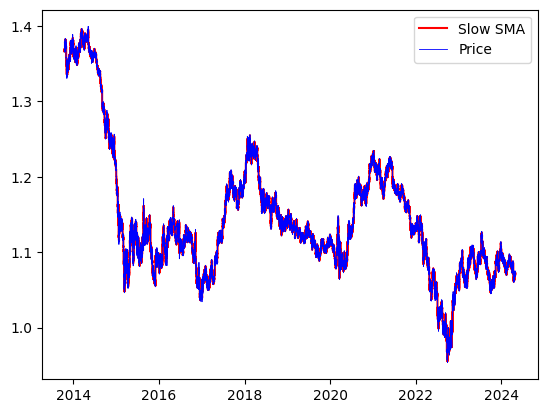

In [13]:
plt.plot(dataset['slow_sma'], '-r', label='Slow SMA')
plt.plot(dataset['Close'], '-b', lw=0.6, label='Price')
plt.legend()
plt.show()

## Machine Learning - Preprocessing

#### Normalizing the dataset
First, we are going to normalize values using min and max scaling results, in this case, we are using only **Close** feature for our predictions.

In [7]:
from sklearn.preprocessing import MinMaxScaler 

# Splitting train and test data.
train, test = dataset[:'2021'], dataset['2022':]

print(train.tail())
print(test.tail())

# Extracting Close feature and converting 1D arrays to 2D arrays
train = np.reshape(train['Close'].values, (-1, 1))
test = np.reshape(test['Close'].values, (-1, 1))

# Defining the scalation type and scaling the training and test datasets with the MixMax scalation type.
scaler = MinMaxScaler(feature_range = (0, 1)) 
scaled_training_set = scaler.fit_transform(train) # S
scaled_test_set = scaler.fit_transform(test) 

print(scaled_training_set[:5])
print("\n")
print(scaled_test_set[:5])

                        Open     High      Low    Close
Time                                                   
2021-12-31 19:30:00  1.13824  1.13850  1.13797  1.13825
2021-12-31 20:00:00  1.13823  1.13848  1.13819  1.13831
2021-12-31 20:30:00  1.13833  1.13851  1.13760  1.13760
2021-12-31 21:00:00  1.13760  1.13793  1.13760  1.13786
2021-12-31 21:30:00  1.13785  1.13822  1.13667  1.13667
                        Open     High      Low    Close
Time                                                   
2024-04-29 21:30:00  1.07219  1.07221  1.07196  1.07205
2024-04-29 22:00:00  1.07203  1.07223  1.07186  1.07188
2024-04-29 22:30:00  1.07189  1.07196  1.07169  1.07173
2024-04-29 23:00:00  1.07173  1.07191  1.07163  1.07179
2024-04-29 23:30:00  1.07178  1.07187  1.07141  1.07147
[[0.15438317]
 [0.15452457]
 [0.15374691]
 [0.15339343]
 [0.15261577]]


[[0.93887806]
 [0.94036509]
 [0.9405702 ]
 [0.94026254]
 [0.9370321 ]]


#### Creating training data structures

In [8]:
X_train = []
y_train = []

for i in range(50, len(scaled_training_set)):
    X_train.append(scaled_training_set[i - 50:i, 0])
    y_train.append(scaled_training_set[i, 0])
    
# The training datasets are converted to Numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (233081, 50, 1) y_train : (233081, 1)


#### Creating test data structures

In [9]:
X_test = []
y_test = []

for i in range(50, len(scaled_test_set)):
    X_test.append(scaled_test_set[i - 50:i, 0])
    y_test.append(scaled_test_set[i, 0])

# The test  datasets are converted to numpy arrays
X_test, y_test = np.array(X_test), np.array(y_test)
 
#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)



X_test : (28961, 50, 1) y_test : (28961, 1)


## Machine Learning - Executing

In [10]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error

2024-04-30 21:40:14.925419: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 21:40:15.000737: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 21:40:15.171803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 21:40:16.109789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
#Initialising the model
regressorLSTM = Sequential()
 
#Adding LSTM layers
regressorLSTM.add(LSTM(50, 
                       return_sequences = True, 
                       input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50, 
                       return_sequences = False))
regressorLSTM.add(Dense(25))
 
#Adding the output layer
regressorLSTM.add(Dense(1))
 
#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
                      loss = 'mean_squared_error',
                      metrics = ["accuracy"])
 
#Fitting the model
regressorLSTM.fit(X_train, 
                  y_train, 
                  batch_size = 32, 
                  epochs = 10)
regressorLSTM.summary()

Epoch 1/10


/home/nicolas/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7284/7284 ━━━━━━━━━━━━━━━━━━━━ 93s 13ms/step - accuracy: 7.5424e-06 - loss: 5.6158e-04
Epoch 2/10
7284/7284 ━━━━━━━━━━━━━━━━━━━━ 95s 13ms/step - accuracy: 2.3107e-06 - loss: 1.3096e-05
Epoch 3/10
7284/7284 ━━━━━━━━━━━━━━━━━━━━ 93s 13ms/step - accuracy: 4.5317e-06 - loss: 7.7598e-06
Epoch 4/10
7284/7284 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - accuracy: 3.3655e-07 - loss: 6.6586e-06
Epoch 5/10
7284/7284 ━━━━━━━━━━━━━━━━━━━━ 92s 13ms/step - accuracy: 1.1408e-05 - loss: 6.2542e-06
Epoch 6/10
7284/7284 ━━━━━━━━━━━━━━━━━━━━ 94s 13ms/step - accuracy: 6.7222e-06 - loss: 5.8970e-06
Epoch 7/10
7284/7284 ━━━━━━━━━━━━━━━━━━━━ 96s 13ms/step - accuracy: 7.9614e-06 - loss: 5.8685e-06
Epoch 8/10
7284/7284 ━━━━━━━━━━━━━━━━━━━━ 97s 13ms/step - accuracy: 1.5688e-05 - loss: 5.6132e-06
Epoch 9/10
7284/7284 ━━━━━━━━━━━━━━━━━━━━ 99s 14ms/step - accuracy: 1.3293e-05 - loss: 5.2580e-06
Epoch 10/10
7284/7284 ━━━━━━━━━━━━━━━━━━━━ 96s 13ms/step - accuracy: 5.1115e-06 - loss: 5.3205e-06


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

#### Testing the LSTM model

In [12]:
y_LSTM = regressorLSTM.predict(X_test)
y_LSTM_O = scaler.inverse_transform(y_LSTM)

906/906 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


#### Plotting model prediction

In [ ]:
plt.figure(figsize=(18, 8))
plt.title("LSTM 30 minute candle prediction model")
# plt.plot(test, label = "Real price", color = "blue", lw=0.7)
plt.plot(y_LSTM_O, label = "LSTM Prediction", color = "orange", lw=0.7)
plt.legend()

plt.xlabel("Time")
plt.ylabel("Close price")
 
plt.show()
print(y_LSTM_O)
print("\n")
print(test)